# Statistical foundation of machine learning

In [2]:
import numpy as np
from prep import TimeWindowTransformer, LabelWindowExtractor

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

# adjust import if needed

## Loading raw data

In [3]:
# loading raw data
# PATH = f'/Users/marco/PROJECTS/data/'
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'guided' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

## (Optional) Signal filtering

if you plan to filter your sEMG signals, it is recommended to perform
this preprocessing step directly on the continuous raw data prior to window extraction or feature
computation. Note that this step is completely optional but may improve your results.

## (0.5 point) Dataset preparation and augmentation through overlapping windows

You should first segment your sEMG signals into smaller windows of fixed size k = 500. These windows should be created with a chosen degree of overlap, which you can adjust based on the computational and memory resources available to you. Keep in mind that a larger overlap results in a greater number of samples and thus a larger dataset to train your models but to the cost of increasing computational demands.

In [4]:
# Define parameters
size = 500
step = 250

# Initialize transformers
tw_transformer = TimeWindowTransformer(size=size, step=step)
label_extractor = LabelWindowExtractor(size=size, step=step)

# Apply transformations
X_windows = tw_transformer.transform(X)     # shape: (5, n_windows, 8, 500)
Y_labels = label_extractor.transform(Y)     # shape: (5, n_windows, 51)

# Inspect shapes
print("X_windows shape:", X_windows.shape)
print("Y_labels shape:", Y_labels.shape)


X_windows shape: (5, 919, 8, 500)
Y_labels shape: (5, 919, 51)


## (1 point) Cross-validation strategy

Determine and implement an adequate cross-validation strategy to validate your regression models, specifying how you organized your data partitions for training and validation. Provide a detailed justification showing that your validation sets remain completely independent from the training set. Include reasoning or evidence demonstrating explicitly that your chosen partitioning strategy prevents data leakage or bias, ensuring the reliability and generalizability of your model performance estimates.

In [5]:
X_train_val_folds = X_windows[:4]
Y_train_val_folds = Y_labels[:4]
X_test = X_windows[4]
Y_test = Y_labels[4]

## (3 points) Baseline approach

Create a custom class inheriting from scikit-learn’s `BaseEstimator`
and `TransformerMixin` that implements the extraction of common time-domain features described
in section 3.1. Note that the features described in Section 3.1 represent the minimal required set. We
encourage you to include additional features or preprocessing steps if you would like to further improve your model performances. Select at least two different regression models, compare their cross-validated performance, and evaluate their feature importances. For both models, perform feature selection to determine the optimal subset of features minimizing the Root Mean Squared Error (RMSE).
Clearly document this process in your notebook, discussing the outcomes in detail. Finally, create a
scikit-learn `Pipeline` that integrates your custom feature extraction class, the optimal feature selection step, and the best-performing regression model identified from your cross-validation results.
Using visualizations and tables to illustrate your findings, and employing formulas or pseudo-code
to explain the feature selection procedure, is strongly encouraged. Note that one-third of the score
will depend on the quality and clarity of your documentation.

**Disclaimer:** EVERY model/pipeline we create MUST take in input a numpy array of shape (N, 8, 500) and return a numpy array of shape (N, 51). The usage is:

model.fit(X, y)  --> Here X is of shape (N, 8, 500), y is of shape (N, 51) ; we are not supposed to use the return of this method, the method changes the model in place.

model.predict(X) --> Here X is of shape (N, 8, 500), and the return is of shape (N, 51)

The transformers have a fit_transform() method, which is the only one used. They take (N, 8, 500) and return something else of shape (N,...) depending on which transformer is used.

#### Baseline models - guided

In [6]:
from prep import TimeDomainTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

from validation import RMSE, NMSE, cross_validate_pipeline

In [7]:
baseline1 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.001,
            kernel='laplacian'))
    ]
)

baseline2 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor())
    ]
)

baseline3 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer()),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())
    ]
)

In [9]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Time domain features + Kernel Ridge': baseline1,
    'Time domain features + KNN': baseline2,
    'Time domain features + Random Forests': baseline3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)



Model: Time domain features + Kernel Ridge

Average Scores across folds:
RMSE: train=0.0181, val=5.1703
NMSE: train=0.0000, val=0.1351

Model: Time domain features + KNN

Average Scores across folds:
RMSE: train=2.0971, val=4.7569
NMSE: train=0.0219, val=0.1144

Model: Time domain features + Random Forests

Average Scores across folds:
RMSE: train=1.1835, val=5.1831
NMSE: train=0.0070, val=0.1388


#### Hyperparameter tuning

In [12]:
from sklearn.model_selection import ParameterGrid

param_grids = {
    'Time domain features + Kernel Ridge': {
        'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        'regressor__gamma': [0.001, 0.01, 0.1]
    },
    'Time domain features + KNN': {
        'regressor__n_neighbors': [3, 5, 7, 10, 13, 16, 20, 25, 30, 40, 50]
    },
    'Time domain features + Random Forests': {
        'regressor__n_estimators': [10, 50, 100],
        'regressor__max_depth': [None, 5, 10]
    }
}

all_results = {}

for model_name, pipeline in models.items():
    print(f"\nTuning Model: {model_name}")
    results = []

    for params in ParameterGrid(param_grids[model_name]):
        pipeline.set_params(**params)
        scores = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)

        results.append({
            'params': params,
            'mean_train_RMSE': scores['avg_train_RMSE'],
            'mean_val_RMSE': scores['avg_val_RMSE'],
            'mean_train_NMSE': scores['avg_train_NMSE'],
            'mean_val_NMSE': scores['avg_val_NMSE']
        })

    all_results[model_name] = results


Model: Time domain features + Kernel Ridge

Model: Time domain features + KNN

Model: Time domain features + Random Forests


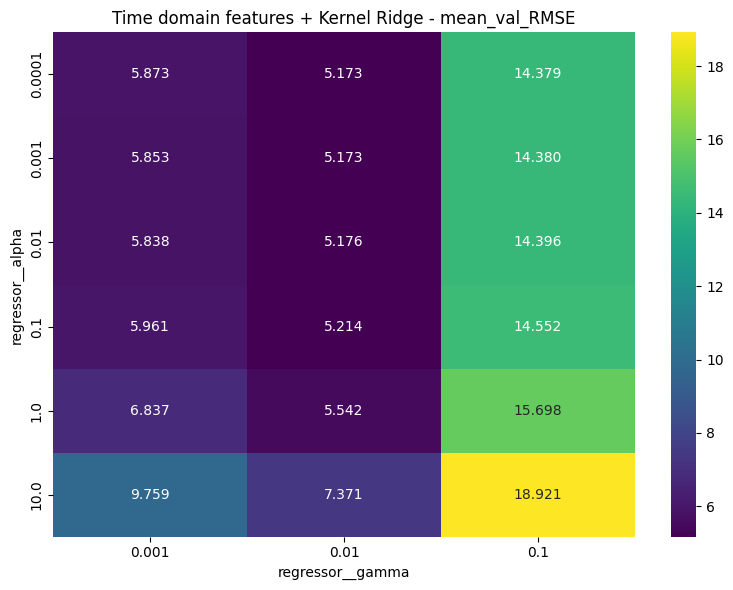

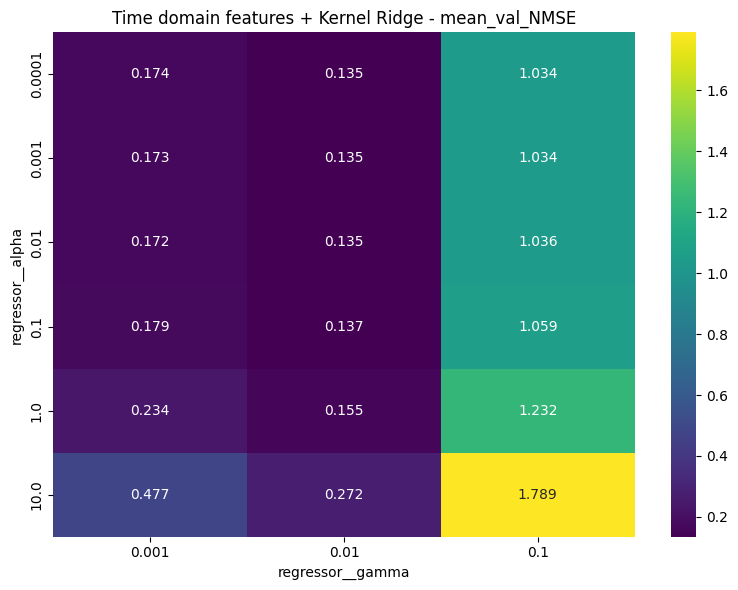

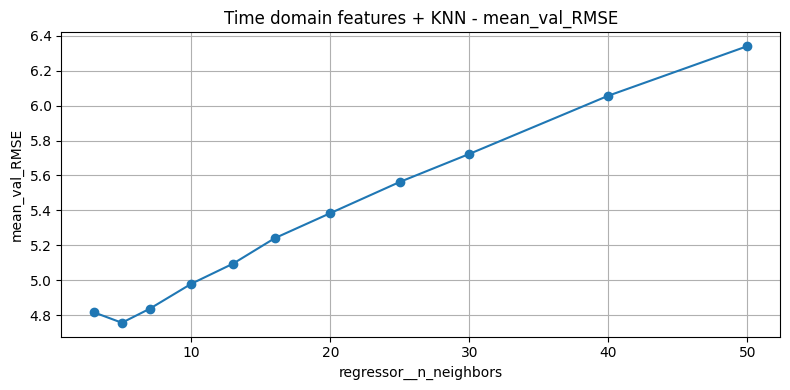

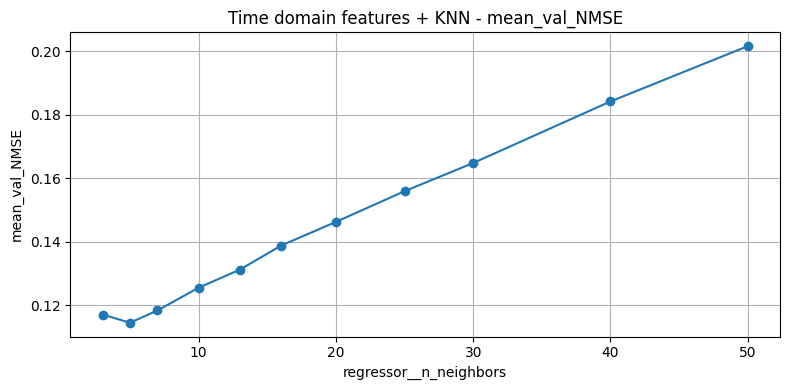

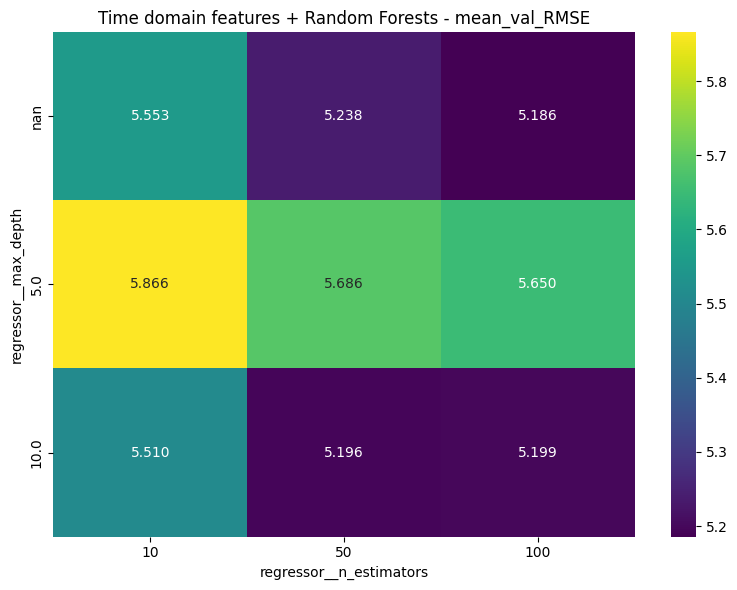

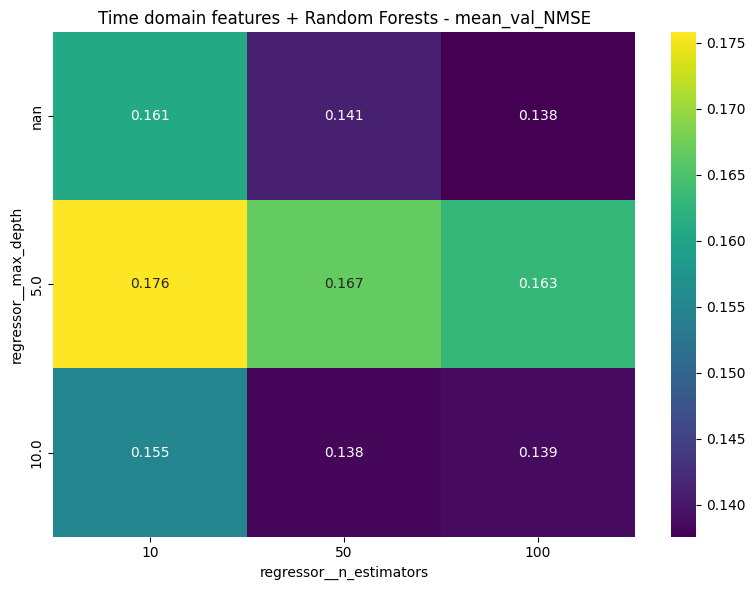

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_grid_results(model_name, results):
    """
    Plots RMSE and NMSE heatmaps for a given model's grid search results.

    Args:
        model_name (str): name of the model
        results (list of dict): results from parameter tuning
    """
    df = pd.DataFrame(results)
    param_cols = [col for col in df['params'][0].keys()]
    for col in param_cols:
        df[f'param_{col}'] = df['params'].apply(lambda d: d[col])

    # Identify unique parameter combinations
    if len(param_cols) == 2:
        p1, p2 = f'param_{param_cols[0]}', f'param_{param_cols[1]}'

        for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
            pivot = df.pivot(index=p1, columns=p2, values=metric)

            plt.figure(figsize=(8, 6))
            sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
            plt.title(f'{model_name} - {metric}')
            plt.xlabel(param_cols[1])
            plt.ylabel(param_cols[0])
            plt.tight_layout()
            plt.show()

    elif len(param_cols) == 1:
        p = f'param_{param_cols[0]}'
        for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
            plt.figure(figsize=(8, 4))
            plt.plot(df[p], df[metric], marker='o')
            plt.xlabel(param_cols[0])
            plt.ylabel(metric)
            plt.title(f'{model_name} - {metric}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

for model_name, results in all_results.items():
    plot_grid_results(model_name, results)

#### Features selection

In [ ]:
# Feature selection
from sklearn.model_selection import KFold

# Flatten and extract time domain features
n_sessions, n_windows, n_channels, window_size = X_train_val_folds.shape
X_flat = X_train_val_folds.reshape(-1, n_channels, window_size)
y_flat = Y_train_val_folds.reshape(-1, 51)[:, 0]  # predict first joint for now

# Apply time-domain transformer manually for feature selection
td_transformer = TimeDomainTransformer()
X_feat = td_transformer.transform(X_flat).reshape(X_flat.shape[0], -1)
X_df = pd.DataFrame(X_feat)
y_series = pd.Series(y_flat)
n = X_df.shape[1]
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Mutual information approximation via correlation
def mutual_info_corr(X, Y):
    c = np.corrcoef(X, Y)[0, 1]
    if abs(c) == 1:
        c = 0.999999
    return -0.5 * np.log(1 - c**2)

def compute_mi_vector(X_tr, Y_tr):
    mis = []
    for col in X_tr.columns:
        mi = mutual_info_corr(X_tr[col].values, Y_tr)
        mis.append(mi)
    return np.array(mis)

# Correlation Ranking - ignores redundancy between features 
correlations = np.abs(X_df.corrwith(y_series))
ranking_corr_idx = correlations.sort_values(ascending=False).index.tolist()
CV_err_corr = np.zeros((n, 4))

for fold_id, (train_index, test_index) in enumerate(kf.split(X_df)):
    X_tr, X_ts = X_df.iloc[train_index], X_df.iloc[test_index]
    Y_tr, Y_ts = y_series[train_index], y_series[test_index]

    for nb_features in range(1, n + 1):
        selected_features = ranking_corr_idx[:nb_features]
        model = KernelRidge()
        model.fit(X_tr[selected_features], Y_tr)
        Y_hat_ts = model.predict(X_ts[selected_features])
        CV_err_corr[nb_features - 1, fold_id] = NMSE(Y_hat_ts, Y_ts)

print("\nCorrelation Ranking")
for i in range(n):
    print(f"#Features: {i+1}; CV error = {CV_err_corr[i,:].mean():.4f}; std dev = {CV_err_corr[i,:].std():.4f}")

In [ ]:
# mRMR Ranking - requires mutual information computation
CV_err_mrmr = np.zeros((n, 4))
for fold_id, (train_index, test_index) in enumerate(kf.split(X_df)):
    X_tr, X_ts = X_df.iloc[train_index], X_df.iloc[test_index]
    Y_tr, Y_ts = y_series[train_index], y_series[test_index]

    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))

    for j in range(n):
        redundancy_score = np.zeros(len(candidates))
        if len(selected) > 0:
            for cidx in candidates:
                col_c = X_tr.iloc[:, cidx]
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx]
                    cc = np.corrcoef(col_s, col_c)[0, 1]
                    if abs(cc) == 1:
                        cc = 0.999999
                    mis_c.append(-0.5 * np.log(1 - cc**2))
                redundancy_score[candidates.index(cidx)] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)

    for nb_features in range(1, n + 1):
        features_to_use = [X_df.columns[i] for i in selected[:nb_features]]
        model = KernelRidge()
        model.fit(X_tr[features_to_use], Y_tr)
        Y_hat_ts = model.predict(X_ts[features_to_use])
        CV_err_mrmr[nb_features - 1, fold_id] = NMSE(Y_hat_ts, Y_ts)

print("\nmRMR Ranking")
for i in range(n):
    print(f"#Features: {i+1}; CV error = {CV_err_mrmr[i,:].mean():.4f}; std dev = {CV_err_mrmr[i,:].std():.4f}")

In [ ]:
# PCA - produces unstructured components (not original features)
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_df)
CV_err_pca = np.zeros((n, 4))
for fold_id, (train_index, test_index) in enumerate(kf.split(X_pca)):
    X_tr, X_ts = X_pca[train_index], X_pca[test_index]
    Y_tr, Y_ts = y_series[train_index], y_series[test_index]

    for nb_components in range(1, n + 1):
        model = KernelRidge()
        model.fit(X_tr[:, :nb_components], Y_tr)
        Y_hat_ts = model.predict(X_ts[:, :nb_components])
        CV_err_pca[nb_components - 1, fold_id] = NMSE(Y_hat_ts, Y_ts)

print("\nPCA Components")
for i in range(n):
    print(f"#Components: {i+1}; CV error = {CV_err_pca[i,:].mean():.4f}; std dev = {CV_err_pca[i,:].std():.4f}")

### Riemannian geometry pipelines

In [ ]:
import pyriemann
import pyriemann.regression
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
# # ----- Riemannian geometry of covariance matrices ----- #
riem1 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', KernelRidge(
            kernel='laplacian'))
    ]
)

riem2 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', KNeighborsRegressor())
    ]
)

riem3 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', RandomForestRegressor())
    ]
)

In [ ]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'riem1': riem1,
    'riem2': riem2,
    'riem3': riem3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)

#### Hyperparameter tuning

In [ ]:
...

### Ensemble regressors

In [ ]:
from ensemble import VotingRegressor

ensemble_estimator = VotingRegressor(
    estimators = [baseline2, riem2]
)

result = cross_validate_pipeline(ensemble_estimator, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=2)

### Estimator validation

### Visualizing predictions to unseen data

In [ ]:
X_train_val_flat = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train_val_flat = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

model = ensemble_estimator

model.fit(X_train_val_flat, Y_train_val_flat)
Y_train_pred = model.predict(X_train_val_flat)
Y_test_pred = model.predict(X_test)

print(f"train RMSE:\t{RMSE(Y_train_pred, Y_train_val_flat):.4f}\ttrain NMSE:\t{NMSE(Y_train_pred, Y_train_val_flat):.4f}")
print(f"test RMSE:\t{RMSE(Y_test_pred, Y_test):.4f}\ttest NMSE:\t{NMSE(Y_test_pred, Y_test):.4f}")

In [ ]:
from visualization_tools import scatter_3d_points

bone = 6
Y_true_bone = Y_test[:,3*bone:3*(bone+1)]
Y_pred_bone = Y_test_pred[:,3*bone:3*(bone+1)]

print(f'RMSE for bone {bone}:', RMSE(Y_pred_bone, Y_true_bone))
print(f'NMSE for bone {bone}:', NMSE(Y_pred_bone, Y_true_bone))

ax = scatter_3d_points(Y_true_bone, color = 'b')
scatter_3d_points(Y_pred_bone, color = 'r', ax = ax)
# ax.set_xlim3d(-50, 50)
# ax.set_ylim3d(-50, 50)
# ax.set_zlim3d(-50, 50)
plt.show()